In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train.csv', 'train(energy).csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train.csv',index_col=0).dropna(axis=0)
print(df.shape)
df.head()

(16498, 403)


,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,...,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
001-01,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.409138,0.433925,0.440811,0.451332,0.454764,1.0,10.0,2.5,100.0,1.0
001-02,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.397878,0.422758,0.429677,0.440263,0.443717,1.0,10.0,5.0,100.0,1.0
001-03,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.385311,0.410579,0.417606,0.428374,0.431884,1.0,10.0,10.0,100.0,1.0
001-04,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.387033,0.409416,0.415640,0.425230,0.428354,1.0,10.0,2.5,100.0,1.5
001-05,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.376672,0.399048,0.405285,0.414893,0.418027,1.0,10.0,5.0,100.0,1.5


# calculate density

In [5]:
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['NA_density','LE_density','HC_density','HE_density'],index=df.index)
density.head()

,NA_density,LE_density,HC_density,HE_density
001-01,0.732839,0.683806,0.734016,0.760288
001-02,0.732839,0.686371,0.734110,0.760618
001-03,0.732839,0.688468,0.734355,0.761531
001-04,0.732839,0.683457,0.733602,0.759290
001-05,0.732839,0.686087,0.733705,0.759360


# duty

In [6]:
duty = df[col_names['duty']]
duty = duty.drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
duty.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr
001-01,2.280675,4.252277
001-02,2.280843,4.071568
001-03,2.280798,3.900158
001-04,2.280843,3.759819
001-05,2.280675,3.607212


# define X,Y

In [7]:
X = df[col_names['case']].join(df[col_names['xna']])
print(X.shape)
X.head()

(16498, 58)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,10.0,2.5,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-02,10.0,5.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-03,10.0,10.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-04,10.0,2.5,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-05,10.0,5.0,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0


In [8]:
Y = duty.join(density)
print(Y.shape)
Y.head()

(16498, 6)


,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
001-01,2.280675,4.252277,0.732839,0.683806,0.734016,0.760288
001-02,2.280843,4.071568,0.732839,0.686371,0.734110,0.760618
001-03,2.280798,3.900158,0.732839,0.688468,0.734355,0.761531
001-04,2.280843,3.759819,0.732839,0.683457,0.733602,0.759290
001-05,2.280675,3.607212,0.732839,0.686087,0.733705,0.759360


# build scale

In [9]:
mm_x = MinMaxScaler()
mm_y = MinMaxScaler()

# scale features

In [10]:
X[:] = mm_x.fit_transform(X[:])
X.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,0.0,0.000000,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-02,0.0,0.333333,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-03,0.0,1.000000,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-04,0.0,0.000000,0.5,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-05,0.0,0.333333,0.5,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0


In [11]:
Y[:] = mm_y.fit_transform(Y[:])
Y.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
001-01,0.500376,0.299170,0.050789,0.292995,0.014472,0.051083
001-02,0.500471,0.281120,0.050790,0.315001,0.015451,0.053848
001-03,0.500445,0.263998,0.050790,0.332987,0.017995,0.061500
001-04,0.500471,0.249981,0.050790,0.290005,0.010181,0.042718
001-05,0.500376,0.234737,0.050789,0.312563,0.011254,0.043307


# split train test

In [12]:
x_col = X.columns.tolist()
y_col = Y.columns.tolist()
df = shuffle(X.join(Y))

In [13]:
X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(13198, 58) (1650, 58) (1650, 58)
(13198, 6) (1650, 6) (1650, 6)


# to torch tensor

In [14]:
X_train = torch.tensor(X_train.values,dtype=torch.float)#.cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float)#.cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float)#.cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float)#.cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float)#.cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float)#.cuda()

# data iter

In [15]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [16]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [17]:
class energy_net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(energy_net,self).__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,128)
        self.fc3 = Linear(128,output_shape)
    
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [18]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [19]:
net = energy_net(len(x_col),len(y_col))#.cuda()
net.apply(init_weights)

energy_net(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

# forward test

In [20]:
net(X_test)

tensor([[0.5405, 0.4032, 0.5418, 0.4800, 0.4946, 0.6395],
        [0.4642, 0.4571, 0.5329, 0.4716, 0.4472, 0.5984],
        [0.4647, 0.3895, 0.5360, 0.5392, 0.3714, 0.5492],
        ...,
        [0.4621, 0.4085, 0.5435, 0.4944, 0.4413, 0.5441],
        [0.4927, 0.4094, 0.5678, 0.5310, 0.3970, 0.5467],
        [0.4780, 0.5357, 0.5946, 0.4106, 0.3699, 0.5881]],
       grad_fn=<SigmoidBackward>)

# torchviz

In [21]:
#y = net(X_test)
#torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))

# tensorboard

In [22]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [23]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [24]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0103 valid loss 0.0027
record net
epochs 1 train loss 0.0023 valid loss 0.0017
record net
epochs 2 train loss 0.0017 valid loss 0.0014
record net
epochs 3 train loss 0.0015 valid loss 0.0012
record net
epochs 4 train loss 0.0013 valid loss 0.0011
record net
epochs 5 train loss 0.0013 valid loss 0.0011
record net
epochs 6 train loss 0.0012 valid loss 0.0010
record net
epochs 7 train loss 0.0012 valid loss 0.0010
epochs 8 train loss 0.0012 valid loss 0.0010
epochs 9 train loss 0.0011 valid loss 0.0010
record net
epochs 10 train loss 0.0011 valid loss 0.0009
record net
epochs 11 train loss 0.0011 valid loss 0.0009
record net
epochs 12 train loss 0.0010 valid loss 0.0010
epochs 13 train loss 0.0010 valid loss 0.0009
record net
epochs 14 train loss 0.0010 valid loss 0.0008
record net
epochs 15 train loss 0.0009 valid loss 0.0008
epochs 16 train loss 0.0009 valid loss 0.0008
record net
epochs 17 train loss 0.0009 valid loss 0.0008
record net
epochs 18 train loss 0.0009 

epochs 163 train loss 0.0001 valid loss 0.0001
epochs 164 train loss 0.0001 valid loss 0.0001
epochs 165 train loss 0.0001 valid loss 0.0001
epochs 166 train loss 0.0001 valid loss 0.0001
epochs 167 train loss 0.0001 valid loss 0.0001
epochs 168 train loss 0.0002 valid loss 0.0001
epochs 169 train loss 0.0001 valid loss 0.0001
epochs 170 train loss 0.0001 valid loss 0.0001
epochs 171 train loss 0.0001 valid loss 0.0001
epochs 172 train loss 0.0001 valid loss 0.0001
epochs 173 train loss 0.0001 valid loss 0.0001
epochs 174 train loss 0.0001 valid loss 0.0001
epochs 175 train loss 0.0001 valid loss 0.0001
epochs 176 train loss 0.0001 valid loss 0.0001
epochs 177 train loss 0.0001 valid loss 0.0001
epochs 178 train loss 0.0001 valid loss 0.0001
epochs 179 train loss 0.0001 valid loss 0.0001
record net
epochs 180 train loss 0.0001 valid loss 0.0001
epochs 181 train loss 0.0001 valid loss 0.0001
epochs 182 train loss 0.0001 valid loss 0.0001
epochs 183 train loss 0.0001 valid loss 0.0001
ep

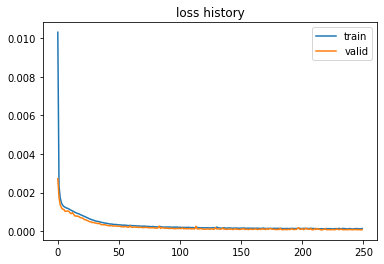

In [25]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [26]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.454996,5.097439,0.740523,0.680417,0.749360,0.767349
1,2.365362,3.839475,0.751777,0.688480,0.757562,0.775942
2,2.174889,3.951231,0.751994,0.695243,0.753977,0.773558
3,1.958360,4.708943,0.751701,0.686070,0.753246,0.771762
4,2.135029,2.372683,0.753835,0.706721,0.753755,0.772637


In [27]:
y_real = Y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.460738,5.103022,0.740623,0.680530,0.749377,0.766969
1,2.361946,3.721601,0.751649,0.688352,0.757713,0.775260
2,2.168367,3.780853,0.752158,0.695486,0.753986,0.772235
3,1.951982,4.715027,0.751864,0.685841,0.753659,0.771663
4,2.138449,2.569629,0.754301,0.709722,0.753800,0.775198


# metric

In [28]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.982227,0.000373271,0.279456
Duty_Reboiler Heat Duty_Mkcal/hr,0.970357,0.0331345,2.39134
NA_density,0.999501,5.99076e-08,0.0206551
LE_density,0.993784,9.56242e-07,0.0696037
HC_density,0.999134,1.10238e-07,0.0320623
HE_density,0.990246,1.7457e-06,0.105597
AVG,0.989208,0.00558511,0.483119


# wrap model

In [29]:
class ANN_energy_wrapper(object):
    def __init__(self,x_col,y_col,mm_x,mm_y,net):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net
    
    def predict(self,x):
        x = self.mm_x.transform(x)
        x = torch.tensor(x,dtype=torch.float)#.cuda()
        y = self.net(x).detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = pd.DataFrame(y,columns=self.y_col)
        assert np.all(y.values >= 0)
        return y

In [30]:
model = ANN_energy_wrapper(x_col,y_col,mm_x,mm_y,net.eval())

# test ANN_wrapper

In [31]:
X_test = mm_x.inverse_transform(X_test.detach().cpu().numpy())
X_test = pd.DataFrame(X_test,columns=x_col)
X_test.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
0,30.0,5.0,100.0,1.5,0.0,0.0,0.0,0.080002,0.160003,1.327027,...,1.014020,2.366047,0.643013,0.587012,0.239005,0.111002,0.014000,0.002,0.003,0.0
1,20.0,5.0,100.0,1.5,0.0,0.0,0.0,0.038999,0.077998,0.650980,...,0.772977,1.803946,0.336990,0.838975,0.328990,0.158995,0.018999,0.003,0.004,0.0
2,30.0,10.0,100.0,0.5,0.0,0.0,0.0,0.023000,0.045999,0.379992,...,0.773984,1.806964,0.936981,0.446991,0.576988,0.084998,0.033999,0.002,0.007,0.0
3,20.0,2.5,90.0,0.3,0.0,0.0,0.0,0.023000,0.045000,0.376000,...,0.798000,1.863000,0.980000,0.466000,0.679000,0.088000,0.040000,0.002,0.008,0.0
4,30.0,10.0,100.0,0.5,0.0,0.0,0.0,0.007000,0.014000,0.114998,...,0.770985,1.798964,0.632987,0.386992,0.553989,0.072999,0.031999,0.001,0.006,0.0


In [32]:
Y_test = mm_y.inverse_transform(Y_test.detach().cpu().numpy())
Y_test = pd.DataFrame(Y_test,columns=y_col)
Y_test.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.460738,5.103022,0.740623,0.680530,0.749377,0.766969
1,2.361946,3.721601,0.751649,0.688352,0.757713,0.775260
2,2.168367,3.780853,0.752158,0.695486,0.753986,0.772235
3,1.951982,4.715027,0.751864,0.685841,0.753659,0.771663
4,2.138449,2.569629,0.754301,0.709722,0.753800,0.775198


In [33]:
Y_pred = model.predict(X_test)
Y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.454996,5.097439,0.740523,0.680417,0.749360,0.767349
1,2.365362,3.839475,0.751777,0.688480,0.757562,0.775942
2,2.174889,3.951231,0.751994,0.695243,0.753977,0.773558
3,1.958360,4.708943,0.751701,0.686070,0.753246,0.771762
4,2.135029,2.372683,0.753835,0.706721,0.753755,0.772637


# metric

In [34]:
y_real = Y_test
y_pred = Y_pred

In [35]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.982227,0.000373272,0.279457
Duty_Reboiler Heat Duty_Mkcal/hr,0.970357,0.0331345,2.39134
NA_density,0.999501,5.99077e-08,0.0206552
LE_density,0.993784,9.56241e-07,0.0696037
HC_density,0.999134,1.10238e-07,0.0320622
HE_density,0.990246,1.7457e-06,0.105597
AVG,0.989208,0.00558511,0.483119


# save model

In [36]:
joblib.dump(model,'../model/ANN(energy).pkl')
print('save done!')

save done!
